In [7]:
%matplotlib inline
import seaborn as sns, numpy as np, cPickle, pandas as pd, pylab,random,cPickle, matplotlib.pyplot as plt
from os import system,listdir
from scipy.cluster.hierarchy import fcluster,linkage,cophenet
from IPython.display import display, HTML
from os.path import join,dirname,basename,isdir
global familymatching_thresh 
from sklearn import decomposition,manifold,preprocessing,metrics
from sklearn.preprocessing import scale,normalize,StandardScaler
from scipy.stats import variation
import matplotlib.cm as cm

topdir = '/cluster/zeng/research/lineage'
codetopdir = '/cluster/zeng/code/research/lineage'
familymatching_thresh = 0

## Multiplex-decoding analysis
Performan analysis on the number of reads corresponding to each of the 8 groups with code under 
```
    python /cluster/zeng/code/research/lineage/index_analysis order
```

#### Summarizing the analysis output

In [11]:
index_topdir = join(codetopdir,'index_analysis')
data= []
mynames = ['endo_t1_trans','undirect_t1_trans','endo_t2_trans','undirect_t2_trans',\
          'endo_t1_fth1','undirect_t1_fth1','endo_t2_fth1','undirect_t2_fth1','undetermined']
for idx in range(len(mynames)):
    mynames[idx] = str(idx+1)+'_'+mynames[idx]
for i in range(4):
    for j in range(1):
        with open(join(index_topdir,'index_analysis_result','lane_'+str(i+1)+'_R'+str(j+1)+'_indexsummary')) as f:
            posdata = [float(x) for x in f]
        label = '_'.join(['lane'+str(i+1)])
        sumdata = float(sum(posdata))
        data += [ [posdata[idx],mynames[idx],label] for idx in range(len(posdata))]
        data += [ [posdata[idx]/sumdata,mynames[idx],label+'_pct'] for idx in range(len(posdata))]

datapd = pd.DataFrame(data,columns=['Value','Index','Label']).pivot('Index','Label','Value')
display(datapd)

Label,lane1,lane1_pct,lane2,lane2_pct,lane3,lane3_pct,lane4,lane4_pct
Index,,,,,,,,
1_endo_t1_trans,14524710,0.207710,14570768,0.203794,13383757,0.201104,13204060,0.198757
2_undirect_t1_trans,9402214,0.134456,9903809,0.138519,8755504,0.131560,8130544,0.122387
3_endo_t2_trans,5941281,0.084963,6221703,0.087020,5412467,0.081328,4434168,0.066746
4_undirect_t2_trans,237650,0.003399,282141,0.003946,235916,0.003545,207304,0.003120
5_endo_t1_fth1,2287483,0.032712,2540852,0.035538,2188699,0.032887,1869695,0.028144
6_undirect_t1_fth1,6233238,0.089138,6500198,0.090915,6164407,0.092626,5799872,0.087304
7_endo_t2_fth1,5553585,0.079419,5599672,0.078320,5246975,0.078841,5481010,0.082504
8_undirect_t2_fth1,5187264,0.074180,5155183,0.072103,5100603,0.076641,4685809,0.070534
9_undetermined,20560461,0.294024,20723293,0.289846,20063168,0.301468,22620612,0.340502


## Decode the multiplexing
Split the reads into 8 groups by running
```
/cluster/zeng/code/research/lineage/splitreads/run_split_reads.sh
/cluster/zeng/code/research/lineage/splitreads/split_result/combine_6and8.sh
```

## Preprocess the reads with indrop pipeline

```
python /cluster/zeng/code/research/lineage/indrops_V2/run.py 1
```

#### Visualize the output to pick cutoff

,Total Reads,Frac. Valid,Valid Reads,Group
0,55683295,0.6281071908549952,34975078,mESC_trans_time1_rep1
1,36192071,0.56288356640326,20371922,mESC_trans_time1_rep2
2,22009619,0.6201914717378797,13650178,mESC_trans_time2_rep1
3,963011,0.508273529585851,489473,mESC_trans_time2_rep2
4,8886729,0.5635319812272884,5007956,mESC_fth1_time1_rep1
5,24697715,0.6240795150482544,15413338,mESC_fth1_time1_rep2
6,21881242,0.622645780344644,13624263,mESC_fth1_time2_rep1
7,20128859,0.6609616074115279,13304403,mESC_fth1_time2_rep2
8,44826574,0.6406409956736823,28717741,mESC_fth1_timeboth_rep2


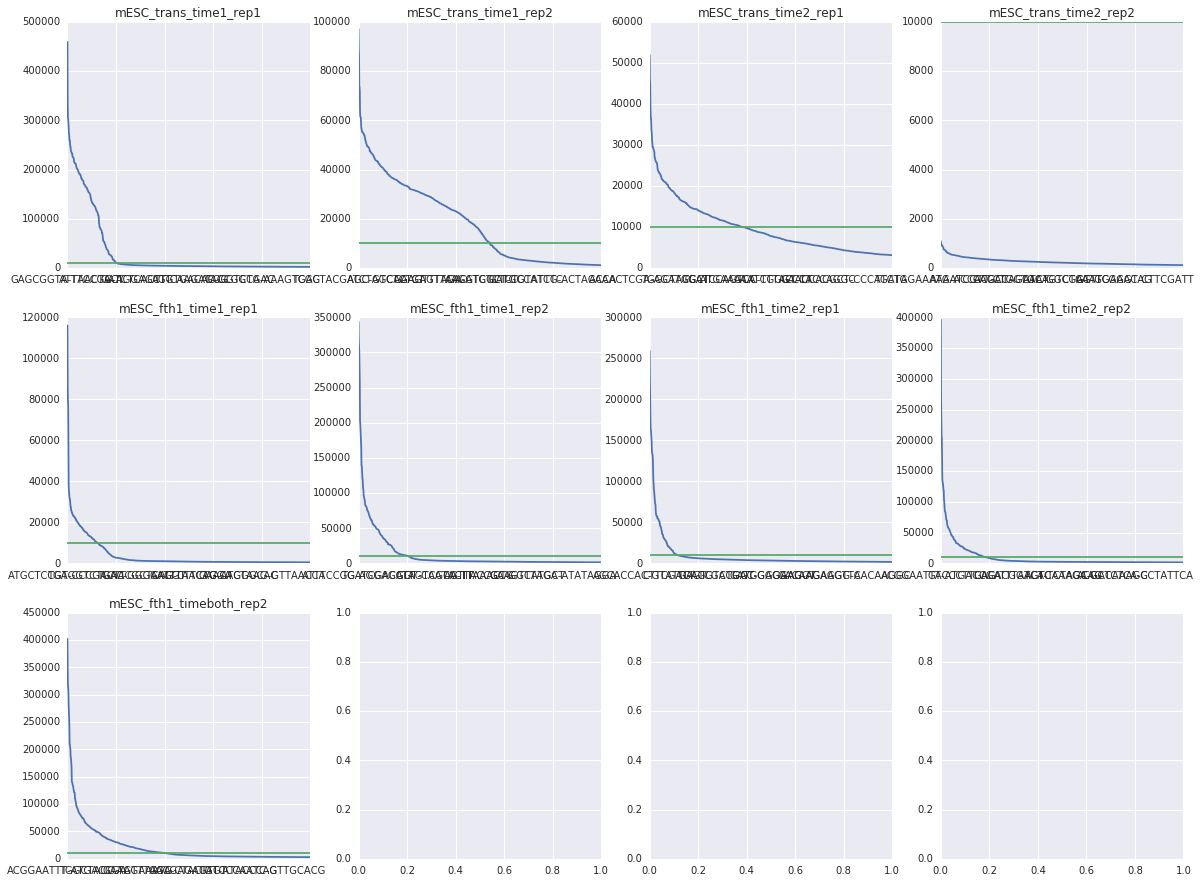

In [46]:
### Check Indrop preprocessing pipeline stats
process_stats = []
cutoff = [10000,4000,7000,200,3000,8000,8000,6000,15000]  ### cutoff to try for each expt
cnt = 0
expts = ['mESC_trans_time1_rep1','mESC_trans_time1_rep2','mESC_trans_time2_rep1','mESC_trans_time2_rep2',\
              'mESC_fth1_time1_rep1','mESC_fth1_time1_rep2','mESC_fth1_time2_rep1','mESC_fth1_time2_rep2',\
              'mESC_fth1_timeboth_rep2']
fig, axs = plt.subplots(int(np.ceil(len(expts)/4.0)), 4,figsize=(20, 15))
for t_expt in expts:
    with open(join(topdir,t_expt,'pre_split','barcode_read_counts.pickle'),'rb') as f:
        data = pd.Series(cPickle.load(f),name=t_expt)
    data.sort_values(ascending=False)[:1000].plot(ax=axs[cnt/4][cnt%4])
    axs[cnt/4][cnt%4].plot(range(1000), [cutoff[i]]*1000)
    axs[cnt/4][cnt%4].set_title(t_expt)
    with open(join(topdir,t_expt,'stats/filtering_metrics.yaml')) as f:
        data = [x.strip().split(': ') for x in f]
        process_stats.append([ data[-3][1],data[-2][1],data[-1][1],t_expt])
    cnt += 1
display(pd.DataFrame(process_stats,columns=['Total Reads','Frac. Valid','Valid Reads','Group']))

#### Compare with data in Jan 2016

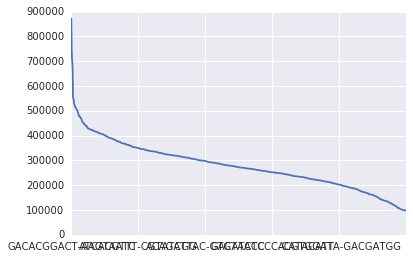

In [41]:
with open(join(topdir,'mESC','pre_split','barcode_read_counts.pickle'),'rb') as f:
    data = pd.Series(cPickle.load(f))
    data.sort_values(ascending=False)[:1000].plot()

## Filter the reads with indrop pipeline part 2
Based on the figures above, pick a reasonable read cutoff for each experiment. Change the cutoff parameter in the following script accordingly and run 
```
python /cluster/zeng/code/research/lineage/indrops_V2/run.py 2
```

#### check the number of cells (droplets) left with the above cutoffs

In [47]:
display(pd.DataFrame([ len([name for name in listdir(join(topdir,t_expt,'post_split/filtered_fastq'))
        if not isdir(join(topdir,t_expt,'post_split/filtered_fastq', name))]) for t_expt in expts],columns=['#cell']))

,#cell
0,205
1,635
2,551
3,545
4,196
5,218
6,144
7,232
8,324


## Lineage barcode extraction
Run 
```
    /cluster/zeng/code/research/lineage/run.sh
```